# Preprocessing

In [1]:
# df.info()

In [2]:
# EDA -> perlu dikumpulin insight"nya

# Preprocessing Steps
# numerical original = 12 -> impute Median (kalo ada)
# numerical original = 12 -> RobustScaler() 
# ohe -> (Complain + 5 categorical original)
# ordinal encoding -> CityTier, SatisfactionScore

# notes: kalo ada missing categorical pake mode (most_frequent)

# smote oversampling -> handle imbalance
# training model, evaluation dapet best model
    # evaluation before hyperparameter tuning, untuk benchmark -> filter candidate models untuk hyperparameter tuning (misal top 3)
    # hyperparamter tuning candidate models from benchmark -> filter best model untuk next steps
# feature importances + confusion matrix (simulation) -> best model aja
# conclusion & recommendations

# tableau -> Dilham
# streamlit -> Hendra
# pptx

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE
from collections import Counter
import joblib

# --- Global variable for reproducibility ---
RANDOM_STATE = 42

# --- 1. Load the dataset ---
try:
    df = pd.read_csv('eda.csv')
    print("Dataset loaded successfully.")
except FileNotFoundError:
    print("Error: 'eda.csv' not found. Please check the file path.")
    exit()

# --- 2. Define features and target ---
TARGET = 'Churn'

# Categorization based on the provided feedback
# CustomerID is not used as features
df.set_index('CustomerID', inplace=True)

# nominal_features = ['PreferedOrderCat', 'MaritalStatus', 'PreferredLoginDevice', 'PreferredPaymentMode']
ordinal_features = ['CityTier', 'SatisfactionScore']
# binary_features = ['Gender'] # 'Complain' already encoded 1 and 0
numerical_features = ['Tenure', 'WarehouseToHome', 'HourSpendOnApp', 'NumberOfDeviceRegistered', 'NumberOfAddress', 'OrderAmountHikeFromlastYear', 'CouponUsed', 'OrderCount', 'DaySinceLastOrder', 'CashbackAmount']
categorical_features = ['PreferedOrderCat', 'MaritalStatus', 'PreferredLoginDevice', 'PreferredPaymentMode', 'Gender', 'Complain']
# gender_categories = [['Male', 'Female']]

# Separate target variable
X = df.drop(columns=[TARGET])
y = df[TARGET]

# --- 3. Split the data to prevent data leakage ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)
print(f"Original data shape: {X.shape}")
print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")
print(f"\nOriginal Churn distribution: {Counter(y)}")
print(f"Training Churn distribution: {Counter(y_train)}")

# --- 4. Define Preprocessing Pipelines ---
# A. Numerical Preprocessor
numerical_preprocessor = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())
])

# B. Nominal Categorical Preprocessor (One-Hot Encoding)
nominal_preprocessor = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# C. Ordinal Categorical Preprocessor (Ordinal Encoding)
ordinal_preprocessor = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), # Impute missing values with the most frequent category
    ('ordinal', OrdinalEncoder())
])

# binary_preprocessor = Pipeline(steps=[
#     ('imputer', SimpleImputer(strategy='most_frequent')),
#     ('ordinal', OrdinalEncoder(categories=[gender_categories[0]]))
# ])

# D. Column Transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_preprocessor, numerical_features),
        ('nominal_cat', nominal_preprocessor, categorical_features),
        ('ordinal_cat', ordinal_preprocessor, ordinal_features),
        # ('binary_cat', binary_preprocessor, binary_features)
    ],
    remainder='passthrough'
)

# # --- 5. Custom Imputation for Missingness Signal ---
# for col in ['WarehouseToHome', 'Tenure', 'OrderCount', 'CouponUsed', 'HourSpendOnApp', 'OrderAmountHikeFromlastYear', 'DaySinceLastOrder']:
#     X_train[f'is_missing_{col}'] = X_train[col].isnull().astype(int)
#     X_test[f'is_missing_{col}'] = X_test[col].isnull().astype(int)

# --- 6. Apply Preprocessing to Data ---
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

print("\nData preprocessing and feature engineering complete.")

# --- 7. Handle Class Imbalance using SMOTE on Training Data Only ---
smote = SMOTE(random_state=RANDOM_STATE)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_processed, y_train)

print(f"\nOriginal training set size: {X_train_processed.shape[0]}")
print(f"Resampled training set size: {X_train_resampled.shape[0]}")
print(f"Resampled Churn distribution: {Counter(y_train_resampled)}")

# --- 8. Final Ready Data for Modeling ---
print("\nPreprocessing workflow complete. The data is now ready for model training.")

# Save the preprocessor
joblib.dump(preprocessor, 'preprocessor.pkl')
print(f"\nPreprocessor saved to 'preprocessor.pkl'")

Dataset loaded successfully.
Original data shape: (5630, 18)
Training data shape: (4504, 18)
Testing data shape: (1126, 18)

Original Churn distribution: Counter({0: 4682, 1: 948})
Training Churn distribution: Counter({0: 3746, 1: 758})

Data preprocessing and feature engineering complete.

Original training set size: 4504
Resampled training set size: 7492
Resampled Churn distribution: Counter({0: 3746, 1: 3746})

Preprocessing workflow complete. The data is now ready for model training.

Preprocessor saved to 'preprocessor.pkl'


In [4]:
# --- 1. Define Tableau Preprocessor (imputation only, no scaling/encoding) ---
numerical_preprocessor_tableau = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))
])

nominal_preprocessor_tableau = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent'))
])

ordinal_preprocessor_tableau = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent'))
])

binary_preprocessor_tableau = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent'))
])

preprocessor_tableau = ColumnTransformer(
    transformers=[
        ('num', numerical_preprocessor_tableau, numerical_features),
        ('nominal_cat', nominal_preprocessor_tableau, categorical_features),
        ('ordinal_cat', ordinal_preprocessor_tableau, ordinal_features),
        # ('binary_cat', binary_preprocessor_tableau, binary_features)
    ],
    remainder='passthrough'
)

# --- 2. Fit on training set, transform whole dataset ---
preprocessor_tableau.fit(X_train)          # fit imputers using training data only
X_all_tableau = preprocessor_tableau.transform(X)   # apply to full dataset

# Get feature names from preprocessor
pt_feature_names = preprocessor_tableau.get_feature_names_out()

# Remove transformer prefixes like "num__", "nominal_cat__", etc.
clean_feature_names = [name.split("__")[-1] for name in pt_feature_names]

# --- 3. Convert back to DataFrame ---
tableau_ready = pd.DataFrame(X_all_tableau, 
                             columns=clean_feature_names)
tableau_ready[TARGET] = y.reset_index(drop=True)
tableau_ready.index = df.index

# --- 4. Save to CSV ---
tableau_ready.to_csv("tableau_ready.csv")
print("\n✅ Tableau-ready dataset saved as 'tableau_ready.csv'")


✅ Tableau-ready dataset saved as 'tableau_ready.csv'


In [2]:
# If X_test is still a DataFrame after preprocessing
test_df = X_test.copy()
test_df['Churn'] = y_test.values

# If X_test is a NumPy array after preprocessing
# you’ll need to bring back the feature names
if not isinstance(X_test, pd.DataFrame):
    feature_names = preprocessor.get_feature_names_out()
    test_df = pd.DataFrame(X_test, columns=feature_names)
    test_df['Churn'] = y_test.values

# Save to CSV for inspection or later use
test_df.to_csv("test_set.csv")

print("Test set saved successfully with shape:", test_df.shape)

Test set saved successfully with shape: (1126, 19)


# Model Train & Evaluation

## Benchmark Model

## Hyperparameter Tuning

In [6]:
import pandas as pd
import numpy as np
import joblib

# Import all necessary models and metrics
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import fbeta_score, roc_auc_score, precision_score, recall_score, classification_report, confusion_matrix, make_scorer

# --- 1. Define Models and Hyperparameter Grids ---
# A dictionary to hold all models and their tuning grids.
models = {
    'LogisticRegression': {
        'model': LogisticRegression(random_state=RANDOM_STATE, solver='liblinear'),
        'params': {
            'C': [0.01, 0.1, 1, 10, 100],
            'penalty': ['l1', 'l2']
        }
    },
    'KNeighborsClassifier': {
        'model': KNeighborsClassifier(),
        'params': {
            'n_neighbors': [3, 5, 7, 9],
            'weights': ['uniform', 'distance']
        }
    },
    'DecisionTreeClassifier': {
        'model': DecisionTreeClassifier(random_state=RANDOM_STATE),
        'params': {
            'max_depth': [5, 10, 15, None],
            'min_samples_split': [2, 5, 10]
        }
    },
    'RandomForestClassifier': {
        'model': RandomForestClassifier(random_state=RANDOM_STATE),
        'params': {
            'n_estimators': [50, 100, 200],
            'max_depth': [5, 10, None],
            'min_samples_leaf': [1, 2, 4]
        }
    },
    'XGBClassifier': {
        'model': XGBClassifier(random_state=RANDOM_STATE, use_label_encoder=False, eval_metric='logloss'),
        'params': {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [3, 5, 7]
        }
    }
}

# --- 2. Custom Scorers for Evaluation ---
f2_scorer = make_scorer(fbeta_score, beta=2)
f3_scorer = make_scorer(fbeta_score, beta=3)
f4_scorer = make_scorer(fbeta_score, beta=4)
precision_scorer = make_scorer(precision_score)
roc_auc_scorer = make_scorer(roc_auc_score)
recall_scorer = make_scorer(recall_score)

scoring_metrics = {
    'F2-Score': f2_scorer,
    'ROC-AUC': roc_auc_scorer,
    'F3-Score': f3_scorer,
    'F4-Score': f4_scorer,
    'Precision': precision_scorer,
    'Recall': recall_scorer
}

# --- 3. Hyperparameter Tuning and Cross-Validation ---
best_models = {}
best_params = {}
best_score = 0
best_model_name = ''

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

print("--- Starting Model Training & Hyperparameter Tuning ---")

for name, item in models.items():
    print(f"\nTraining and tuning {name}...")
    
    grid_search = GridSearchCV(
        estimator=item['model'],
        param_grid=item['params'],
        scoring=f2_scorer,
        cv=cv,
        n_jobs=-1,
        verbose=1
    )
    
    grid_search.fit(X_train_resampled, y_train_resampled)
    
    best_models[name] = grid_search.best_estimator_
    best_params[name] = grid_search.best_params_
    
    print(f"Best parameters for {name}: {grid_search.best_params_}")
    print(f"Best F2-Score on training data: {grid_search.best_score_:.4f}")

# --- 4. Final Evaluation on the Test Set ---
print("\n--- Final Model Evaluation on the Test Set ---")
results = []

for name, model in best_models.items():
    print(f"\nEvaluating {name}...")
    y_pred = model.predict(X_test_processed)
    y_pred_proba = model.predict_proba(X_test_processed)[:, 1] if hasattr(model, 'predict_proba') else None

    f2 = fbeta_score(y_test, y_pred, beta=2)
    roc_auc = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else 'N/A'
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f3 = fbeta_score(y_test, y_pred, beta=3)
    f4 = fbeta_score(y_test, y_pred, beta=4)
    conf_matrix = confusion_matrix(y_test, y_pred)

    results.append({
        'Model': name,
        'F2-Score': f2,
        'ROC-AUC': roc_auc,
        'F3-Score': f3,
        'F4-Score': f4,
        'Precision': precision,
        'Recall': recall
    })
    
    print(f"Classification Report for {name}:\n")
    print(classification_report(y_test, y_pred, zero_division=0))
    print(f"Confusion Matrix for {name}:\n")
    print(conf_matrix)

# --- 5. Decide the Best Model ---
results_df = pd.DataFrame(results).sort_values(by='F2-Score', ascending=False)
print("\n--- Final Results Summary (Sorted by F2-Score) ---")
print(results_df.to_string(index=False))

best_model = results_df.iloc[0]
print(f"\nFinal Best Model: {best_model['Model']} with an F2-Score of {best_model['F2-Score']:.4f}")

best_model_name = results_df.iloc[0]['Model']
best_model_instance = best_models[best_model_name]

# Save the best model
joblib.dump(best_model_instance, 'best_benchmark_model.pkl')
print(f"\nBest model '{best_model_name}' saved to 'best_benchmark_model.pkl'")

--- Starting Model Training & Hyperparameter Tuning ---

Training and tuning LogisticRegression...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters for LogisticRegression: {'C': 100, 'penalty': 'l1'}
Best F2-Score on training data: 0.8356

Training and tuning KNeighborsClassifier...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters for KNeighborsClassifier: {'n_neighbors': 3, 'weights': 'distance'}
Best F2-Score on training data: 0.9815

Training and tuning DecisionTreeClassifier...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters for DecisionTreeClassifier: {'max_depth': None, 'min_samples_split': 2}
Best F2-Score on training data: 0.9495

Training and tuning RandomForestClassifier...
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best parameters for RandomForestClassifier: {'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 100}
Best F2-Score on training data: 0.9810

Training and 

/home/hendra/.pyenv/versions/purwadhika-jcdsol19/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [22:10:40] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/hendra/.pyenv/versions/purwadhika-jcdsol19/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [22:10:40] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/hendra/.pyenv/versions/purwadhika-jcdsol19/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [22:10:41] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/hendra/.pyenv/versions/purwadhika-jcdsol19/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [22:10:41] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not

Best parameters for XGBClassifier: {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200}
Best F2-Score on training data: 0.9829

--- Final Model Evaluation on the Test Set ---

Evaluating LogisticRegression...
Classification Report for LogisticRegression:

              precision    recall  f1-score   support

           0       0.96      0.79      0.87       936
           1       0.44      0.82      0.58       190

    accuracy                           0.80      1126
   macro avg       0.70      0.81      0.72      1126
weighted avg       0.87      0.80      0.82      1126

Confusion Matrix for LogisticRegression:

[[741 195]
 [ 34 156]]

Evaluating KNeighborsClassifier...
Classification Report for KNeighborsClassifier:

              precision    recall  f1-score   support

           0       0.99      0.92      0.96       936
           1       0.72      0.96      0.82       190

    accuracy                           0.93      1126
   macro avg       0.86      0.94      0.8

Test Load Model

In [7]:
# import joblib
# import pandas as pd
# import numpy as np
# from sklearn.metrics import classification_report, fbeta_score

# # Assuming the following variables are available from your previous script:
# # X_test_processed, y_test, and best_model_name

# # --- 1. Load the saved model ---
# try:
#     best_model_instance = joblib.load('best_benchmark_model.pkl')
#     print("Model 'best_benchmark_model.pkl' loaded successfully.")
    
# except FileNotFoundError:
#     print("Error: The model file 'best_benchmark_model.pkl' was not found.")
#     best_model_instance = None

# if best_model_instance:
#     # --- 2. Make predictions on the test set ---
#     y_pred_loaded = best_model_instance.predict(X_test_processed)
    
#     # --- 3. Evaluate the loaded model's performance ---
#     f2_loaded = fbeta_score(y_test, y_pred_loaded, beta=2)
    
#     print("\n--- Evaluation of Loaded Model ---")
#     print(f"Loaded model's F2-Score on test set: {f2_loaded:.4f}")
#     print("\nClassification Report of Loaded Model:")
#     print(classification_report(y_test, y_pred_loaded))

#     # --- 4. Cross-check with the original best model's score ---
#     # This assumes you have the 'best_model_name' and the 'best_models' dictionary from the previous cell
#     # You can get the score of the original best model by re-evaluating it.
#     y_pred_original = best_models[best_model_name].predict(X_test_processed)
#     f2_original = fbeta_score(y_test, y_pred_original, beta=2)
    
#     print(f"\nOriginal best model's F2-Score: {f2_original:.4f}")

#     if np.isclose(f2_loaded, f2_original):
#         print("✅ Success: The scores match. The model was loaded correctly.")
#     else:
#         print("❌ Warning: The scores do not match. There might be an issue with the saved model.")

# Feature Importances

In [13]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import fbeta_score, classification_report, roc_auc_score, precision_score
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# --- 2. Feature Importance & Selection (Corrected) ---
print("\n--- Feature Importance Analysis ---")

# The fix is to use the more robust preprocessor.get_feature_names_out() method
# This correctly gets the names for all features, including those from One-Hot Encoding and passthrough.
feature_names = preprocessor.get_feature_names_out()

target_n_features = 20

if hasattr(best_model_instance, 'feature_importances_'):
    importances = best_model_instance.feature_importances_
    feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
    
    print(f"Top {target_n_features} Most Important Features:")
    print(feature_importance_df.head(target_n_features).to_string(index=False))

    # --- 3. Retrain on Important Features Only ---
    top_features_list = feature_importance_df['Feature'].head(target_n_features).tolist()

    # Get the indices of the top features in the processed data
    top_feature_indices = [np.where(feature_names == f)[0][0] for f in top_features_list]

    # Create the new reduced datasets by slicing the processed data
    X_train_reduced_resampled = X_train_resampled[:, top_feature_indices]
    X_test_reduced_processed = X_test_processed[:, top_feature_indices]

    print(f"\nTraining on a reduced set of {len(top_features_list)} features.")
    
    # Retrain the best model with its best parameters on the reduced feature set
    simplified_model = best_model_instance.__class__(**best_model_instance.get_params())
    simplified_model.fit(X_train_reduced_resampled, y_train_resampled)

    # --- 4. Evaluate and Compare ---
    # Predictions for the original model
    y_pred_original = best_model_instance.predict(X_test_processed)
    y_pred_proba_original = best_model_instance.predict_proba(X_test_processed)[:, 1] if hasattr(best_model_instance, 'predict_proba') else None
    
    # Predictions for the simplified model
    y_pred_simplified = simplified_model.predict(X_test_reduced_processed)
    y_pred_proba_simplified = simplified_model.predict_proba(X_test_reduced_processed)[:, 1] if hasattr(simplified_model, 'predict_proba') else None

    # Calculate metrics for original model
    f2_original = fbeta_score(y_test, y_pred_original, beta=2)
    f3_original = fbeta_score(y_test, y_pred_original, beta=3)
    f4_original = fbeta_score(y_test, y_pred_original, beta=4)
    precision_original = precision_score(y_test, y_pred_original)
    roc_auc_original = roc_auc_score(y_test, y_pred_proba_original) if y_pred_proba_original is not None else 'N/A'

    # Calculate metrics for simplified model
    f2_simplified = fbeta_score(y_test, y_pred_simplified, beta=2)
    f3_simplified = fbeta_score(y_test, y_pred_simplified, beta=3)
    f4_simplified = fbeta_score(y_test, y_pred_simplified, beta=4)
    precision_simplified = precision_score(y_test, y_pred_simplified)
    roc_auc_simplified = roc_auc_score(y_test, y_pred_proba_simplified) if y_pred_proba_simplified is not None else 'N/A'


    print("\n--- Performance Comparison (Full vs. Simplified Model) ---")
    results_df = pd.DataFrame({
        'Metric': ['F2-Score', 'ROC-AUC', 'F3-Score', 'F4-Score', 'Precision'],
        'Full Model': [f2_original, roc_auc_original, f3_original, f4_original, precision_original],
        'Simplified Model': [f2_simplified, roc_auc_simplified, f3_simplified, f4_simplified, precision_simplified]
    })
    print(results_df.to_string(index=False))

    print("\nSimplified Model Classification Report:")
    print(classification_report(y_test, y_pred_simplified))

    if f2_simplified >= (f2_original * 0.95):
        print("\nConclusion: The simplified model performs comparably to the full model.")
        print("This model is more interpretable and can be used for the Streamlit simulation.")
        joblib.dump(simplified_model, 'simplified_best_model.pkl')
        joblib.dump(top_features_list, 'simplified_features.pkl')
        print("Simplified model and its feature list saved successfully.")
    else:
        print("\nConclusion: The performance drop is significant.")
        print("It is recommended to use the full model for the simulation to maintain accuracy.")
else:
    print("The best model does not have a 'feature_importances_' attribute.")


--- Feature Importance Analysis ---
Top 20 Most Important Features:
                                           Feature  Importance
                                       num__Tenure    0.120086
             nominal_cat__PreferedOrderCat_Grocery    0.108384
                           nominal_cat__Complain_0    0.106523
  nominal_cat__PreferedOrderCat_Laptop & Accessory    0.051318
                     num__NumberOfDeviceRegistered    0.050162
        nominal_cat__PreferedOrderCat_Mobile Phone    0.050098
             nominal_cat__PreferedOrderCat_Fashion    0.047481
                           nominal_cat__Complain_1    0.039626
                              num__NumberOfAddress    0.030921
                 nominal_cat__MaritalStatus_Single    0.030809
                             ordinal_cat__CityTier    0.029241
        nominal_cat__PreferredPaymentMode_E wallet    0.027469
    nominal_cat__PreferredLoginDevice_Mobile Phone    0.026886
                nominal_cat__MaritalStatus_Marrie

/home/hendra/.pyenv/versions/purwadhika-jcdsol19/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [22:13:47] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- Performance Comparison (Full vs. Simplified Model) ---
   Metric  Full Model  Simplified Model
 F2-Score    0.960929          0.917722
  ROC-AUC    0.998459          0.993511
 F3-Score    0.959410          0.916754
 F4-Score    0.958785          0.916357
Precision    0.973262          0.925532

Simplified Model Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       936
           1       0.93      0.92      0.92       190

    accuracy                           0.97      1126
   macro avg       0.95      0.95      0.95      1126
weighted avg       0.97      0.97      0.97      1126


Conclusion: The simplified model performs comparably to the full model.
This model is more interpretable and can be used for the Streamlit simulation.
Simplified model and its feature list saved successfully.



--- Feature Importance & SHAP Analysis ---
Top 20 Most Important Features (Model-based):
                                           Feature  Importance
                                       num__Tenure    0.120086
             nominal_cat__PreferedOrderCat_Grocery    0.108384
                           nominal_cat__Complain_0    0.106523
  nominal_cat__PreferedOrderCat_Laptop & Accessory    0.051318
                     num__NumberOfDeviceRegistered    0.050162
        nominal_cat__PreferedOrderCat_Mobile Phone    0.050098
             nominal_cat__PreferedOrderCat_Fashion    0.047481
                           nominal_cat__Complain_1    0.039626
                              num__NumberOfAddress    0.030921
                 nominal_cat__MaritalStatus_Single    0.030809
                             ordinal_cat__CityTier    0.029241
        nominal_cat__PreferredPaymentMode_E wallet    0.027469
    nominal_cat__PreferredLoginDevice_Mobile Phone    0.026886
                nominal_cat_

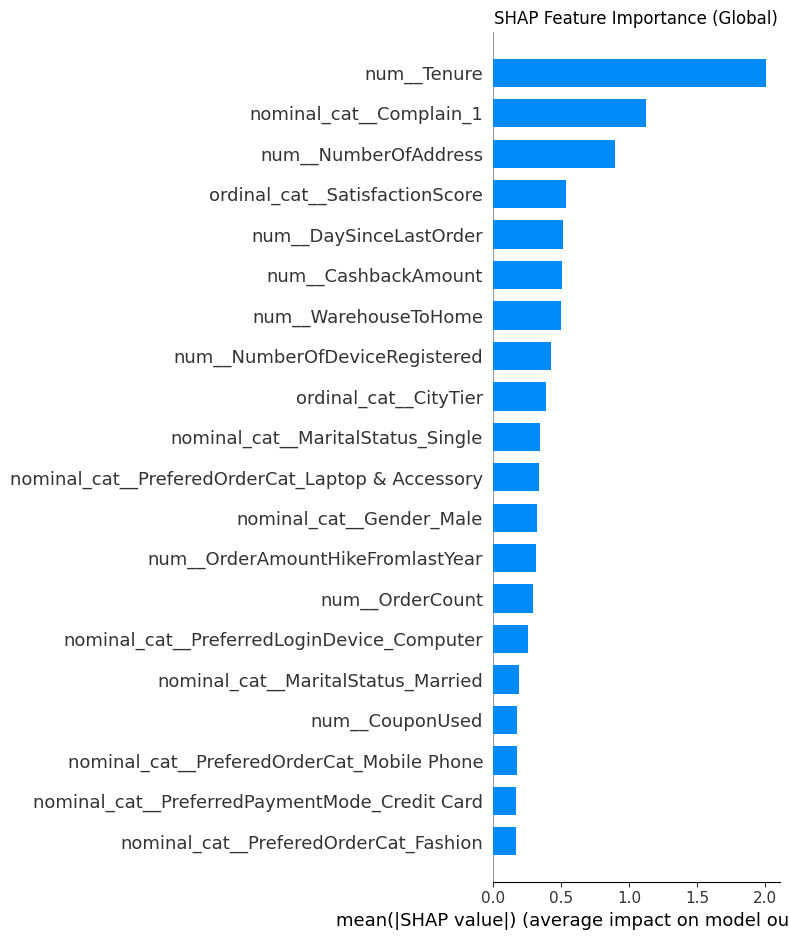

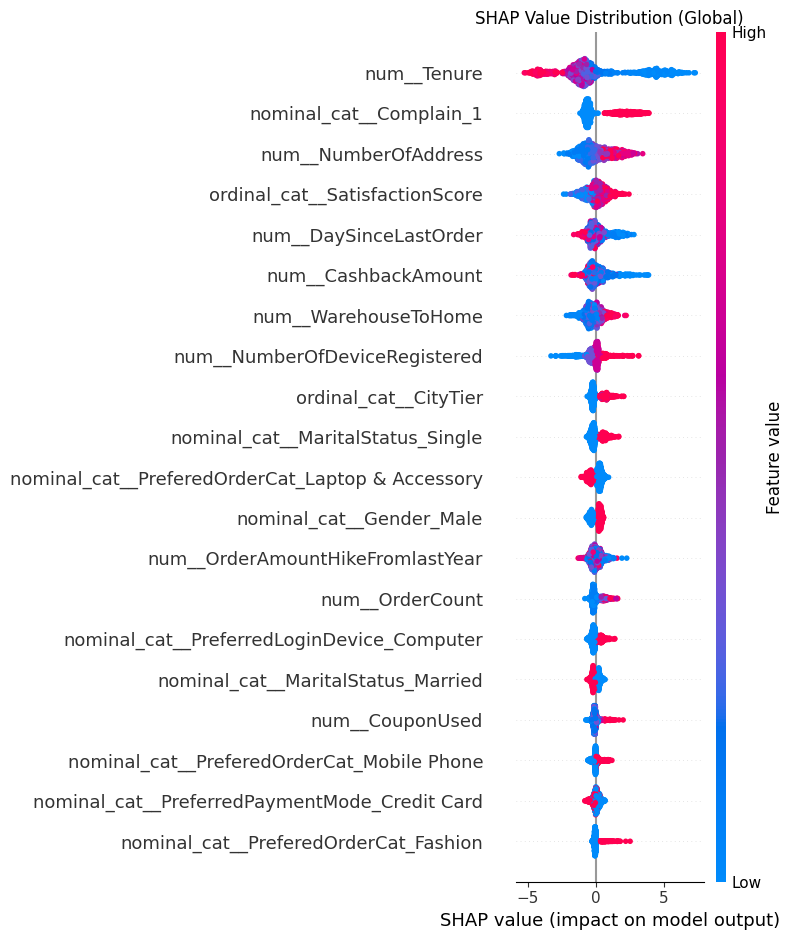

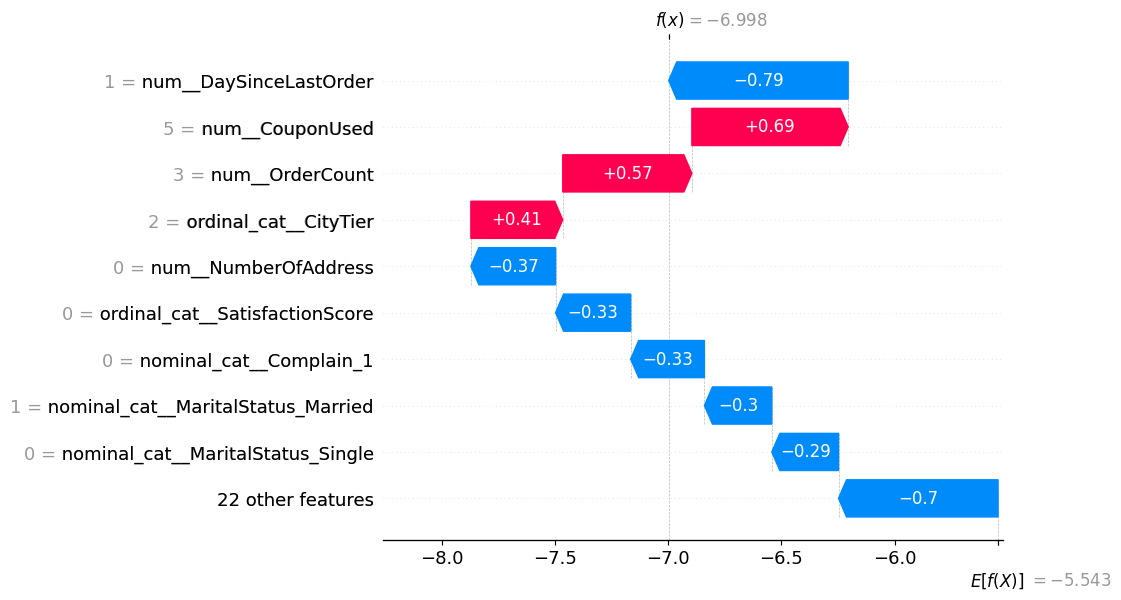

In [14]:
import shap

# --- 2. Feature Importance & SHAP Analysis ---
print("\n--- Feature Importance & SHAP Analysis ---")

# Get feature names from preprocessor
feature_names = preprocessor.get_feature_names_out()

target_n_features = 20

# --- Tree-based models (with feature_importances_) ---
if hasattr(best_model_instance, 'feature_importances_'):
    importances = best_model_instance.feature_importances_
    feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
    
    print(f"Top {target_n_features} Most Important Features (Model-based):")
    print(feature_importance_df.head(target_n_features).to_string(index=False))

# --- SHAP Analysis ---
print("\n--- SHAP Value Analysis ---")

# Use a sample of the test set for SHAP (to save time & memory)
# X_sample = X_test_processed[:200]
X_sample = X_test_processed.copy()

# Initialize SHAP explainer
try:
    explainer = shap.Explainer(best_model_instance, X_sample, feature_names=feature_names)
    shap_values = explainer(X_sample)

    # SHAP summary plot (bar plot for global importance)
    shap.summary_plot(shap_values, X_sample, feature_names=feature_names, plot_type="bar", show=False)
    plt.title("SHAP Feature Importance (Global)")
    plt.tight_layout()
    plt.show()

    # SHAP beeswarm plot (distribution of feature impacts)
    shap.summary_plot(shap_values, X_sample, feature_names=feature_names, show=False)
    plt.title("SHAP Value Distribution (Global)")
    plt.tight_layout()
    plt.show()

    # Optional: visualize a single prediction
    shap.plots.waterfall(shap_values[0])

except Exception as e:
    print(f"SHAP analysis failed: {e}")

# --- Continue with Reduced Feature Training as in your original code ---


In [10]:
# import pandas as pd
# import numpy as np
# import joblib
# import matplotlib.pyplot as plt
# import seaborn as sns
# from sklearn.metrics import fbeta_score

# # --- Load the preprocessed data and best model instance ---
# try:
#     # Assuming these variables are available from your previous script
#     # This is a placeholder for reproducibility
#     # You would not need to re-load in a continuous notebook session
#     preprocessor = joblib.load('preprocessor.pkl')
#     loaded_model = joblib.load('best_benchmark_model.pkl')
    
#     # Get feature names and importances
#     feature_names = preprocessor.get_feature_names_out()
#     importances = loaded_model.feature_importances_
    
#     # Create DataFrame of all features and their importances
#     full_feature_importance_df = pd.DataFrame({
#         'Feature': feature_names,
#         'Importance': importances
#     }).sort_values(by='Importance', ascending=False).reset_index(drop=True)
    
#     print("Loaded model and feature importances.")
# except FileNotFoundError:
#     print("Error: Files not found. Please ensure preprocessor.pkl and best_benchmark_model.pkl are in your directory.")
#     exit()

# # --- 1. Set up the evaluation loop ---
# f2_scores = []
# num_features = []
# total_features = len(full_feature_importance_df)

# print("\n--- Evaluating Models with Varying Number of Features ---")
# # Loop through a range of features, from 1 to the total
# for k in range(1, total_features + 1):
#     # Select the top k features
#     top_k_features = full_feature_importance_df['Feature'].head(k).tolist()
#     top_k_indices = [np.where(feature_names == f)[0][0] for f in top_k_features]
    
#     # Create the reduced datasets
#     X_train_reduced = X_train_resampled[:, top_k_indices]
#     X_test_reduced = X_test_processed[:, top_k_indices]
    
#     # Retrain the model on the reduced dataset
#     simplified_model = loaded_model.__class__(**loaded_model.get_params())
#     simplified_model.fit(X_train_reduced, y_train_resampled)
    
#     # Evaluate and store the F2-score
#     y_pred = simplified_model.predict(X_test_reduced)
#     f2 = fbeta_score(y_test, y_pred, beta=2)
    
#     f2_scores.append(f2)
#     num_features.append(k)
    
#     if k % 10 == 0 or k == total_features:
#         print(f"Evaluated with {k} features. F2-Score: {f2:.4f}")

# # --- 2. Plot the results ---
# results_df = pd.DataFrame({'Number of Features': num_features, 'F2-Score': f2_scores})

# plt.figure(figsize=(12, 7))
# sns.lineplot(x='Number of Features', y='F2-Score', data=results_df, marker='o', color='b')
# plt.title('Model Performance vs. Number of Features', fontsize=18)
# plt.xlabel('Number of Features', fontsize=14)
# plt.ylabel('F2-Score', fontsize=14)
# plt.grid(True)

# # Annotate the best-performing point
# best_score_index = np.argmax(results_df['F2-Score'])
# best_k = results_df['Number of Features'][best_score_index]
# best_f2 = results_df['F2-Score'][best_score_index]
# plt.scatter(best_k, best_f2, color='red', s=100, zorder=5)
# plt.text(best_k, best_f2, f'  Best F2: {best_f2:.4f}\n  at {best_k} features', ha='left', va='bottom', fontsize=12)

# plt.show()

# print("\n--- Conclusion ---")
# print(f"The highest F2-Score achieved is {best_f2:.4f} with {best_k} features.")
# print("Examine the plot to find the 'elbow'—the point where the score plateaus.")
# print("This indicates the minimum number of features needed to maintain strong performance.")

# 📊 Churn Analysis Insights & Recommendations

## 🔎 Key Insights from SHAP & Feature Importance
1. **Tenure (Customer Lifetime)**  
   - The strongest driver of churn.  
   - Customers with short tenure are much more likely to churn.  

2. **Complain (Service Issues)**  
   - Strongly increases churn risk.  
   - Unresolved complaints are a major churn trigger.  

3. **Number of Address (Household Complexity)**  
   - Customers with multiple addresses are more engaged and less likely to churn.  
   - Customers with only one address are at higher risk.  

4. **Satisfaction Score**  
   - Lower satisfaction directly correlates with higher churn.  

5. **Cashback & Order Behavior**  
   - Higher cashback reduces churn probability.  
   - Long inactivity (high DaySinceLastOrder) and low order counts increase churn risk.  

6. **Demographics & Preferences**  
   - Single customers churn more often than married ones.  
   - Customers in certain order categories (e.g., Fashion, Mobile Phone) are more volatile.  
   - Payment mode also reflects churn patterns (e.g., Cash on Delivery users may churn more).  

---

## 📈 Conclusions
- Churn is concentrated among **new, dissatisfied, or inactive customers**.  
- **Customer support quality** and **engagement incentives** are key levers for churn reduction.  
- Retention strategies should be **segmented** by tenure, satisfaction, and activity level.  

---

## ✅ Business Recommendations
1. **Onboarding & Early Retention**
   - Create a **“first 3 months” program** with discounts, loyalty points, or personalized offers.  
   - Send reactivation nudges if **DaySinceLastOrder > median (≈2–3 days)**.  

2. **Customer Support & Complaints**
   - Implement a **24-hour SLA** for complaint resolution.  
   - Provide compensation (e.g., coupons, cashback) after service failures.  

3. **Satisfaction Monitoring**
   - Run post-purchase **satisfaction/NPS surveys**.  
   - Target customers with scores ≤3 with recovery campaigns.  

4. **Cashback & Loyalty Programs**
   - Expand cashback or loyalty tiers for **at-risk customers**.  
   - Reward repeat purchases through **points-based loyalty programs**.  

5. **Behavior-Based Retention**
   - Trigger reactivation offers if customers become inactive.  
   - Offer personalized discounts for volatile segments like **Fashion** or **Mobile Phone** buyers.  

6. **Segmentation & Personalization**
   - Focus on **Single + Short Tenure + Low Satisfaction** as the **highest-risk churn cluster**.  
   - Customize campaigns by **City Tier** (e.g., Tier-2/3 may be more price-sensitive).  

---

## ⚡ Business Impact
- Reducing churn from **16% → 10% monthly** can significantly improve retention.  
- Over a year, this could yield **>20% higher customer retention**.  
- Since acquiring new customers costs **5–7x more** than retaining existing ones, these strategies provide substantial ROI.  
